## Analyse taxonomy for a subset of known pathogens

In [2]:
import sys
import os
import logging
from IPython import get_ipython
logger = logging.getLogger(name="Diversity analysis app")

if 'google.colab' in str(get_ipython()):
    print('Setting Google colab, you will need a ngrok account to make the dashboard display over the tunnel. \
    https://ngrok.com/')
    # clone the momics-demos repository to use it to load data
    try:
        os.system('git clone https://github.com/palec87/momics-demos.git')
        logger.info(f"Repository cloned")
    except OSError as e:
        logger.info(f"An error occurred while cloning the repository: {e}")

    sys.path.insert(0,'/content/momics-demos')

    # this step takes time beacause of many dependencies
    os.system('pip install marine-omics')

from momics.utils import (
    memory_load, reconfig_logger,
    init_setup, get_notebook_environment,
)

# Set up logging
reconfig_logger()

# Determine the notebook environment
env = get_notebook_environment()

init_setup()
logger.info(f"Environment: {env}")

INFO | root | Logging.basicConfig completed successfully
INFO | Diversity analysis app | Environment: vscode
INFO | Diversity analysis app | Environment: vscode


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import panel as pn

from mgo.udal import UDAL
from momics.utils import load_and_clean, taxonomy_common_preprocess01

### Loading

In [4]:
# parquet files
if 'google.colab' in str(get_ipython()):
    root_folder = os.path.abspath(os.path.join('/content/momics-demos'))
else:
    root_folder = os.path.abspath(os.path.join('../'))

assets_folder = os.path.join(root_folder, 'assets')

In [5]:
def get_valid_samples():
    df_valid = pd.read_csv(
        os.path.join(root_folder, 'data/shipment_b1b2_181.csv')
    )
    return df_valid

valid_samples = get_valid_samples()

In [6]:
# High level function from the momics.utils module
full_metadata, mgf_parquet_dfs = load_and_clean(valid_samples=valid_samples)

/home/david-palecek/miniforge3/envs/momics-demos/lib/python3.13/site-packages/momics/metadata.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata["replicate_info"] = (


In [7]:
lsu= mgf_parquet_dfs['lsu']
ssu = mgf_parquet_dfs['ssu']
del mgf_parquet_dfs

In [8]:
lsu.head()

abundance superkingdom kingdom  \
source material ID ncbi_tax_id                                   
EMOBON_BPNS_So_5   2157              21.0      Archaea    None   
                   743725             5.0      Archaea           
                   28890              3.0      Archaea           
                   29291              5.0      Archaea           
                   183967             1.0      Archaea           

                                                   phylum            class  \
source material ID ncbi_tax_id                                               
EMOBON_BPNS_So_5   2157                              None             None   
                   743725       Candidatus_Diapherotrites             None   
                   28890                    Euryarchaeota             None   
                   29291                    Euryarchaeota  Methanomicrobia   
                   183967                   Euryarchaeota   Thermoplasmata   

                                            order              family  \
source material ID ncbi_tax_id                                          
EMOBON_BPNS_So_5   2157                      None                None   
                   743725                    None                None   
                   28890                     None                None   
                   29291        Methanosarcinales  Methanosarcinaceae   
                   183967                    None                None   

                                           genus                    species  
source material ID ncbi_tax_id                                               
EMOBON_BPNS_So_5   2157                     None                       None  
                   743725                   None                       None  
                   28890                    None                       None  
                   29291        Methanococcoides  Methanococcoides_burtonii  
                   183967                   None                       None

### Define genus names to look for

In [9]:
genus_list = [
    "Escherichia",
    "Salmonella",
    "Shigella",
    "Campylobacter",
    "Legionella",
    "Pseudomonas",
    "Vibrio",
    "Aeromonas"
]

In [79]:
df = ssu[(ssu['genus'].isin(genus_list)) & (ssu['abundance'] > 20)]
df.head()

,,abundance,superkingdom,kingdom,phylum,class,order,family,genus,species
source material ID,ncbi_tax_id,,,,,,,,,
EMOBON_BPNS_So_6,662,377.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,None
EMOBON_BPNS_So_13,662,5206.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,None
EMOBON_AAOT_Wa_6,286,25.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,None
EMOBON_AAOT_Wa_7,286,27.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,None
EMOBON_AAOT_Wa_26,662,177.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,None


In [81]:
# pivot table in order to stack the plot
pivot = df.pivot_table(
    index='source material ID',
    columns="genus",       # or other grouping column
    values="abundance",
    aggfunc="sum",
    fill_value=0
).sort_values(by='Vibrio', ascending=False)


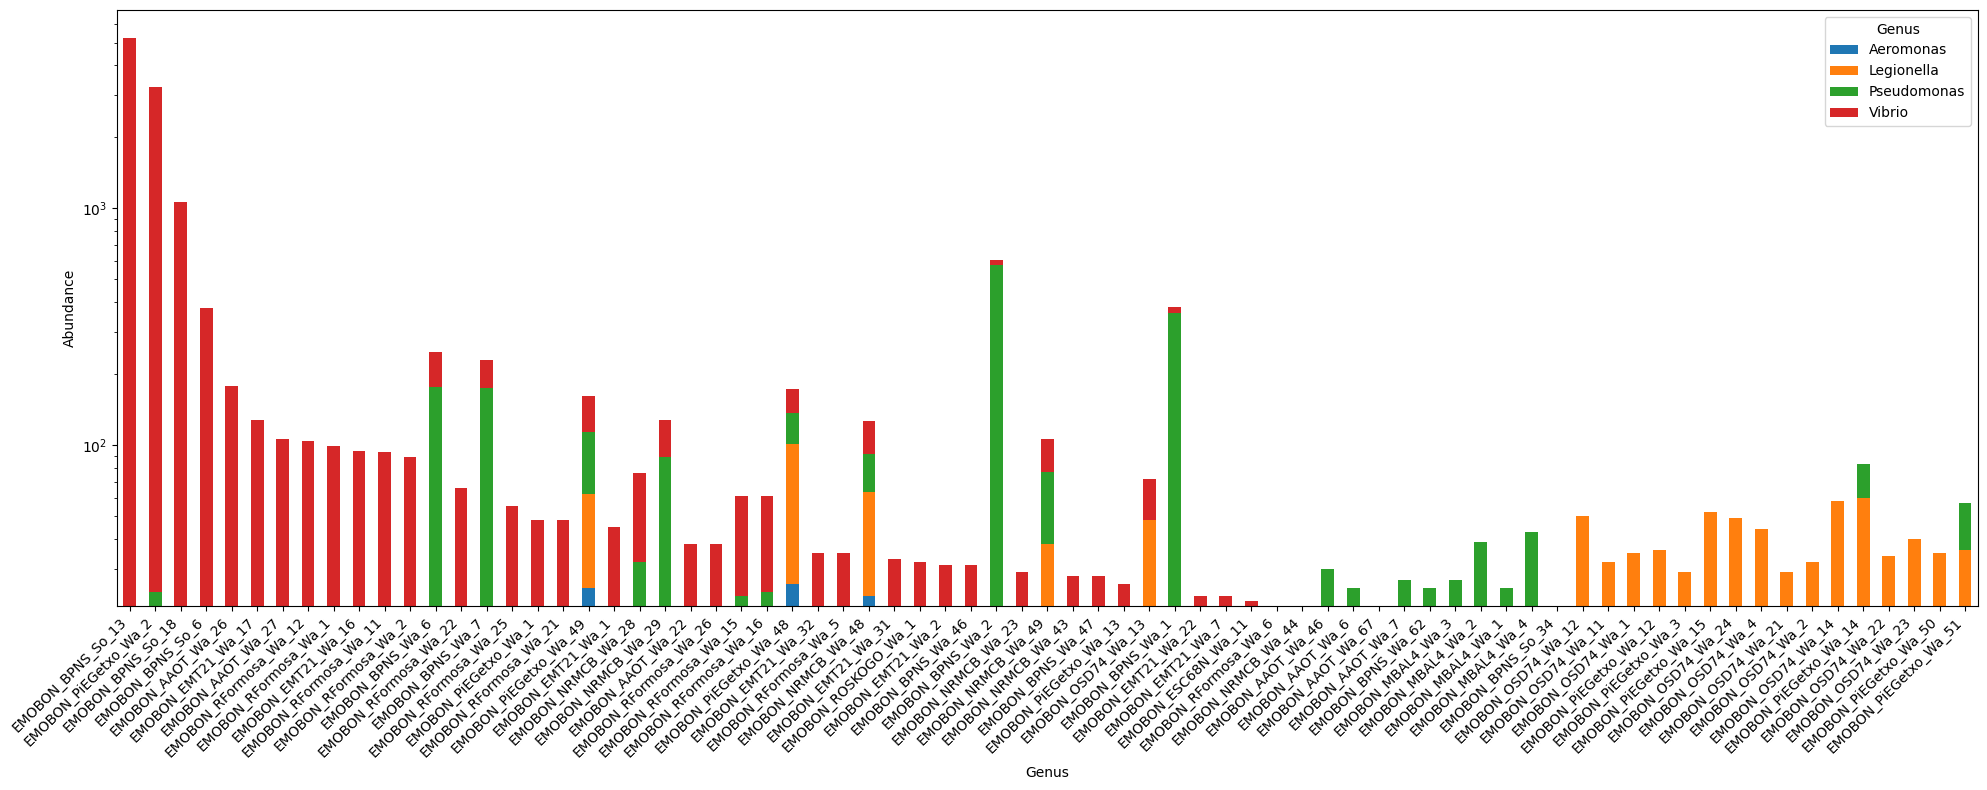

In [82]:
# Plot stacked bars
pivot.plot(
    kind="bar",
    stacked=True,
    figsize=(20, 8),
)

plt.yscale('log')
plt.xticks(rotation=45, ha="right")
plt.ylabel("Abundance")
plt.xlabel("Genus")
plt.legend(title="Genus")
plt.tight_layout()
plt.show()

In [77]:
pivot.head()

genus,Legionella,Pseudomonas,Vibrio
source material ID,,,
EMOBON_BPNS_So_13,0.0,0.0,5206.0
EMOBON_PiEGetxo_Wa_2,0.0,0.0,3220.0
EMOBON_BPNS_So_18,0.0,0.0,1063.0
EMOBON_BPNS_So_6,0.0,0.0,377.0
EMOBON_AAOT_Wa_26,0.0,0.0,177.0


### Iterative approach over a list
- produces separate barplots

########## GENUS Salmonella ###########


,,abundance,superkingdom,kingdom,phylum,class,order,family,genus,species
source material ID,ncbi_tax_id,,,,,,,,,
EMOBON_NRMCB_Wa_29,28901,1.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella_enterica


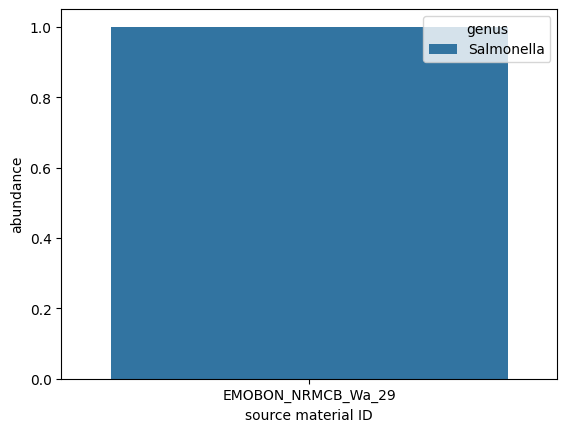

########## GENUS Campylobacter ###########


,,abundance,superkingdom,kingdom,phylum,class,order,family,genus,species
source material ID,ncbi_tax_id,,,,,,,,,
EMOBON_NRMCB_So_6,194,2.0,Bacteria,,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,None
EMOBON_BPNS_Wa_1,194,2.0,Bacteria,,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,None
EMOBON_PiEGetxo_Wa_3,194,2.0,Bacteria,,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,None
EMOBON_RFormosa_Wa_1,194,2.0,Bacteria,,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,None
EMOBON_OOB_So_25,194,2.0,Bacteria,,Proteobacteria,Epsilonproteobacteria,Campylobacterales,Campylobacteraceae,Campylobacter,None


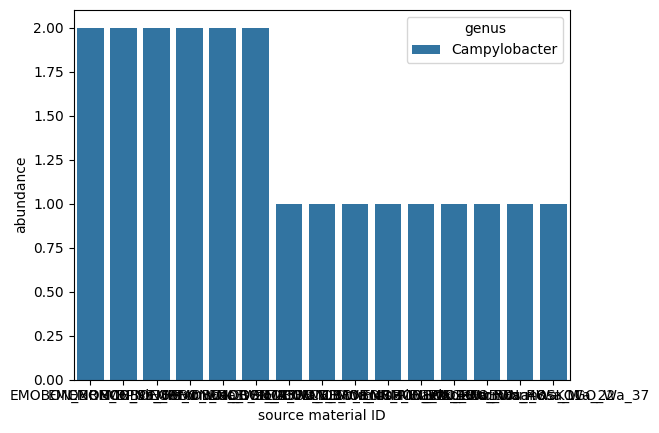

########## GENUS Legionella ###########


,,abundance,superkingdom,kingdom,phylum,class,order,family,genus,species
source material ID,ncbi_tax_id,,,,,,,,,
EMOBON_PiEGetxo_Wa_48,445,75.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Legionellales,Legionellaceae,Legionella,None
EMOBON_PiEGetxo_Wa_14,445,60.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Legionellales,Legionellaceae,Legionella,None
EMOBON_OSD74_Wa_14,445,58.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Legionellales,Legionellaceae,Legionella,None
EMOBON_PiEGetxo_Wa_15,445,52.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Legionellales,Legionellaceae,Legionella,None
EMOBON_OSD74_Wa_12,445,50.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Legionellales,Legionellaceae,Legionella,None


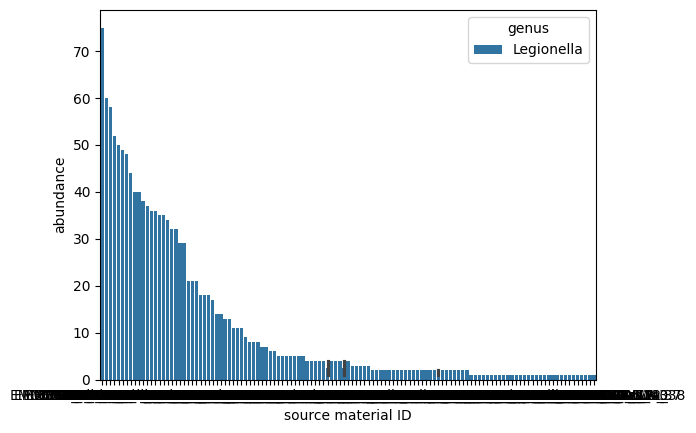

########## GENUS Pseudomonas ###########


,,abundance,superkingdom,kingdom,phylum,class,order,family,genus,species
source material ID,ncbi_tax_id,,,,,,,,,
EMOBON_BPNS_Wa_2,286,574.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,None
EMOBON_BPNS_Wa_1,286,361.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,None
EMOBON_BPNS_Wa_6,286,175.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,None
EMOBON_BPNS_Wa_7,286,174.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,None
EMOBON_NRMCB_Wa_29,286,68.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Pseudomonadales,Pseudomonadaceae,Pseudomonas,None


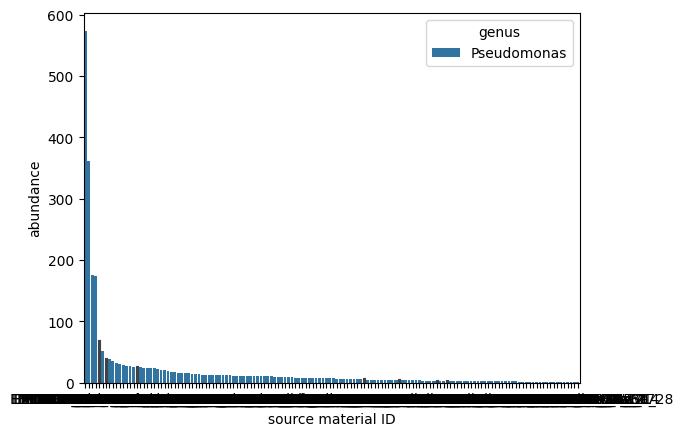

########## GENUS Vibrio ###########


,,abundance,superkingdom,kingdom,phylum,class,order,family,genus,species
source material ID,ncbi_tax_id,,,,,,,,,
EMOBON_BPNS_So_13,662,5206.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,None
EMOBON_PiEGetxo_Wa_2,662,3220.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,None
EMOBON_BPNS_So_18,662,1063.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,None
EMOBON_BPNS_So_6,662,377.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,None
EMOBON_AAOT_Wa_26,662,177.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Vibrio,None


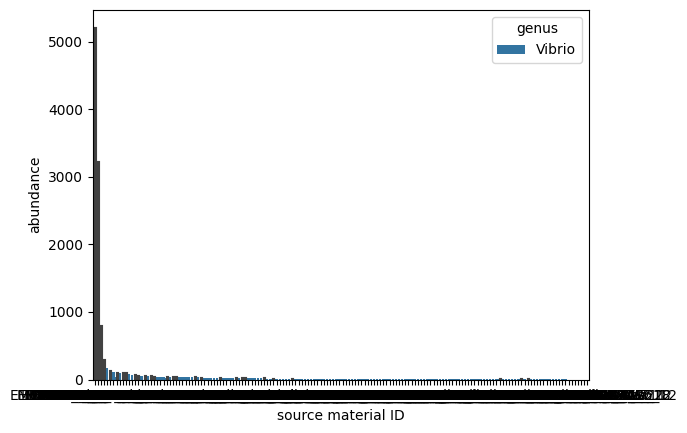

########## GENUS Aeromonas ###########


,,abundance,superkingdom,kingdom,phylum,class,order,family,genus,species
source material ID,ncbi_tax_id,,,,,,,,,
EMOBON_PiEGetxo_Wa_48,642,26.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas,None
EMOBON_PiEGetxo_Wa_49,642,25.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas,None
EMOBON_NRMCB_Wa_48,642,23.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas,None
EMOBON_PiEGetxo_Wa_51,642,15.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas,None
EMOBON_OSD74_Wa_23,642,13.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Aeromonadales,Aeromonadaceae,Aeromonas,None


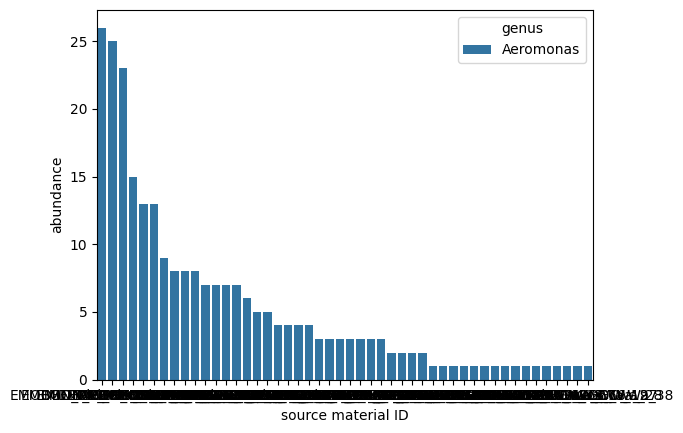

In [59]:
# search ssu table for matches at genus level
for genus in genus_list:
    df = ssu[ssu['genus']==genus].sort_values(by='abundance', ascending=False)
    if not df.empty:
        print(f"########## GENUS {genus} ###########")
        display(df.head())
        # barplot
        df_reset = df.reset_index()
        sns.barplot(
            df_reset,
            x='source material ID',
            y='abundance',
            hue='genus'
        )
        plt.show()

In [13]:
df_reset.head()

,source material ID,ncbi_tax_id,abundance,superkingdom,kingdom,phylum,class,order,family,genus,species
0,EMOBON_NRMCB_Wa_29,28901,1.0,Bacteria,,Proteobacteria,Gammaproteobacteria,Enterobacterales,Enterobacteriaceae,Salmonella,Salmonella_enterica


Note: you can match on `ncbi_tax_id` in the same manner

### Visualization